In [65]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
conn = sqlite3.connect("airbnb_cartagena.sqlite")
df_attributes = pd.read_sql_query("SELECT * FROM Attributes", conn)
df_time_series = pd.read_sql_query("SELECT * FROM TimeSeriesInterpolated", conn)
conn.close()


'''df_attributes=df_attributes[['Name', 'Host', 'Base fee', 'Cleaning fee', 'URL', 'ID', 'latitude',
       'longitude', 'Property type', 'Person capacity', 'accuracy_rating',
       'checking_rating', 'cleanliness_rating', 'communication_rating',
       'location_rating', 'value_rating', 'satisfaction_rating', 'Reviews',
       'Bedrooms', 'Beds', 'Baths', 'City skyline view', 'Beach view',
       'Sea/Lake view', 'Hot water', 'Jacuzzi', 'Shared pool', 'Shared gym',
       'Patio or balcony', 'Outdoor furniture', 'Outdoor playground',
       'Elevator', 'Carport', 'Dedicated workspace', 'AC', 'Heating', 'TV',
       'Cable TV', 'Wifi', 'Laundry service', 'Kitchen', 'Dining table',
       'Microwave', 'Dishes and silverware', 'Refrigerator', 'Stove',
        'Washer', 'Pets allowed',
     'Crib', 
        'Security cameras', 'Lock on door', 'Keypad']]'''

#df_attributes["Base fee"]=df_attributes["Base fee"].map(lambda x:  min(x//35*35+15,105+15)) 
df_attributes.head()


,Name,Host,Base fee,Cleaning fee,URL,ID,latitude,longitude,Property type,Person capacity,...,Room-darkening shades,Window guards,Security cameras,Lock on door,Keypad,Fire extinguisher,First aid kit,Smoke detector,Luggage dropoff,Self check-in
0,14th Floor/Jacuzzi balcony/SeaViews/Parking/King,Alejandra,95.0,38.0,https://www.airbnb.ca/rooms/128289097755583918...,1282890977555839180,10.456400,-75.505410,Entire serviced apartment,5.0,...,1,0,1,0,0,1,1,1,1,1
1,2 BR Modern APT jacuzzi / Rooftop near to beach,Alberto,100.0,35.0,https://www.airbnb.com/rooms/12559080218421979...,1255908021842197930,10.456549,-75.505265,Entire rental unit,6.0,...,0,0,0,0,0,0,0,0,0,0
2,Piso 12/ Jacuzzi/ Vistas/ 1BR/Parqueadero/Pisc...,Alejandra,67.0,36.0,https://www.airbnb.mx/rooms/136437655186096193...,1364376551860961934,10.456523,-75.505361,Entire serviced apartment,4.0,...,1,0,1,0,0,0,1,1,1,1
3,Piso 14/ Jacuzzi/ Vistas/ 2BR/Parqueadero/Pisc...,Alejandra,89.0,36.0,https://www.airbnb.mx/rooms/127921819131081724...,1279218191310817247,10.456398,-75.505406,Entire serviced apartment,5.0,...,1,0,1,0,0,1,1,1,1,1
4,Luxury /Jacuzzi/ Decoration/ Caribbean/ Pools/,Alejandra,81.0,36.0,https://www.airbnb.mx/rooms/125978025681811266...,1259780256818112667,10.456398,-75.505406,Entire serviced apartment,4.0,...,1,0,1,0,0,1,1,1,1,1


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from scipy.spatial.distance import pdist, squareform
from sklearn.linear_model import LinearRegression
from datetime import datetime
import matplotlib.pyplot as plt
import umap
import plotly.express as px
import plotly.colors as pc
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import gudhi as gd

c:\Users\EdsonAlvarez\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:

def plot_umap_svd_space(df_space, color_column=None, discrete_colorscale=False):
    """
    Gráfico 3D del espacio embebido (UMAP)
    """
    df_plot = df_space.copy()

    if color_column:
        df_plot = df_plot.merge(df_attributes[['ID', color_column]], on='ID', how='left')
        
        color_values = df_plot[color_column]
    else:
        color_values = None

    fig = px.scatter_3d(
        df_plot,
        x="UMAP1", y="UMAP2", z="UMAP3",
        color=color_values,
        hover_name="ID",
        color_continuous_scale="amp",
        opacity=0.85,
        title="Espacio Embebido (UMAP)",
        template="plotly_dark"
    )
    
    fig.update_layout(
        margin={"r":0, "t":40, "l":0, "b":0},
        paper_bgcolor="#111111",
        plot_bgcolor="#111111",
        font=dict(color="white"),
        scene=dict(
            xaxis=dict(title="UMAP1", backgroundcolor="#111111", gridcolor="gray"),
            yaxis=dict(title="UMAP2", backgroundcolor="#111111", gridcolor="gray"),
            zaxis=dict(title="UMAP3", backgroundcolor="#111111", gridcolor="gray")
        )
    )
    return fig

In [4]:


def plot_rips_complex_3d(df_space, simplex_tree, color_column=None):
    """
    Visualiza en 3D el complejo de Vietoris-Rips (puntos + aristas).
    """
    df_plot = df_space.copy()

    # Extraer coordenadas 3D
    coords = df_plot[["UMAP1", "UMAP2", "UMAP3"]].values
    id_map = dict(zip(df_plot["ID"], range(len(df_plot))))  # ID a índice

    # Color opcional
    if color_column:
        df_plot = df_plot.merge(df_attributes[['ID', color_column]], on='ID', how='left')
        color_values = df_plot[color_column]
    else:
        color_values = None

    # --- Crear trazas de aristas (1-símplices) ---
    edges = []
    for simplex, filtration in simplex_tree.get_skeleton(1):
        if len(simplex) == 2:
            i, j = simplex
            xi, yi, zi = coords[i]
            xj, yj, zj = coords[j]
            edges.append(go.Scatter3d(
                x=[xi, xj, None],  # None para separar segmentos
                y=[yi, yj, None],
                z=[zi, zj, None],
                mode='lines',
                line=dict(color='white', width=1),
                hoverinfo='none',
                showlegend=False
            ))

    # --- Crear traza de puntos ---
    scatter = go.Scatter3d(
        x=df_plot["UMAP1"],
        y=df_plot["UMAP2"],
        z=df_plot["UMAP3"],
        mode='markers',
        marker=dict(
            size=4,
            color=color_values if color_column else 'lightblue',
            opacity=0.8,
            colorbar=dict(title=color_column) if color_column else None
        ),
        text=df_plot["ID"],
        name="Puntos"
    )

    # --- Figura final ---
    fig = go.Figure(data=[scatter] + edges)
    fig.update_layout(
        title="Complejo de Vietoris–Rips en espacio UMAP",
        template="plotly_dark",
        margin=dict(l=0, r=0, b=0, t=40),
        scene=dict(
            xaxis_title="UMAP1",
            yaxis_title="UMAP2",
            zaxis_title="UMAP3",
            xaxis=dict(backgroundcolor="#111111", gridcolor="gray"),
            yaxis=dict(backgroundcolor="#111111", gridcolor="gray"),
            zaxis=dict(backgroundcolor="#111111", gridcolor="gray")
        )
    )
    return fig


In [5]:
def plot_rips_projections(df_space, simplex_tree, color_column=None):
    """
    Muestra proyecciones XY, XZ, YZ del complejo de Rips con subplots.
    """
    df_plot = df_space.copy()
    coords = df_plot[["UMAP1", "UMAP2", "UMAP3"]].values

    # Opcional: colorear por variable
    if color_column:
        df_plot = df_plot.merge(df_attributes[['ID', color_column]], on='ID', how='left')
        color_values = df_plot[color_column]
    else:
        color_values = 'lightblue'

    # Crear figura con 3 subplots
    fig = make_subplots(
        rows=1, cols=3,
        subplot_titles=("UMAP1 vs UMAP2", "UMAP1 vs UMAP3", "UMAP2 vs UMAP3"),
        horizontal_spacing=0.05
    )

    # Aristas (1-símplices)
    def get_edges(dim1, dim2):
        edge_traces = []
        for simplex, _ in simplex_tree.get_skeleton(1):
            if len(simplex) == 2:
                i, j = simplex
                xi, yi = coords[i, dim1], coords[i, dim2]
                xj, yj = coords[j, dim1], coords[j, dim2]
                edge_traces.append(go.Scatter(
                    x=[xi, xj, None], y=[yi, yj, None],
                    mode='lines',
                    line=dict(color='gray', width=1),
                    hoverinfo='none',
                    showlegend=False
                ))
        return edge_traces

    # Nodos (puntos)
    scatter_args = dict(
        mode='markers',
        marker=dict(
            size=4,
            color=color_values,
            showscale=True if color_column else False,
            opacity=0.8,
            colorbar=dict(title=color_column) if color_column else None
        ),
        text=df_plot["ID"],
        hoverinfo='text'
    )

    # --- Subplot 1: XY ---
    for trace in get_edges(0, 1): fig.add_trace(trace, row=1, col=1)
    fig.add_trace(go.Scatter(
        x=df_plot["UMAP1"], y=df_plot["UMAP2"], **scatter_args
    ), row=1, col=1)

    # --- Subplot 2: XZ ---
    for trace in get_edges(0, 2): fig.add_trace(trace, row=1, col=2)
    fig.add_trace(go.Scatter(
        x=df_plot["UMAP1"], y=df_plot["UMAP3"], **scatter_args
    ), row=1, col=2)

    # --- Subplot 3: YZ ---
    for trace in get_edges(1, 2): fig.add_trace(trace, row=1, col=3)
    fig.add_trace(go.Scatter(
        x=df_plot["UMAP2"], y=df_plot["UMAP3"], **scatter_args
    ), row=1, col=3)

    fig.update_layout(
            height=500,
            width=1200,
            title_text="Proyecciones del complejo de Vietoris–Rips (1-símplices)",
            template="plotly_dark",
            margin=dict(l=20, r=20, t=60, b=20),
    )
    return fig


In [66]:



columnas_fecha = []
for col in df_time_series.columns:
    try:
        datetime.strptime(col.strip(), "%d/%m/%Y")
        columnas_fecha.append(col)
    except ValueError:
        continue


df_prices = df_time_series.melt(
    id_vars=["ID"],
    value_vars=columnas_fecha,
    var_name="Date",
    value_name="Value"
)
df_prices["Date"] = pd.to_datetime(df_prices["Date"])
ids_con_nan = df_prices[df_prices["Value"].isna()]["ID"].unique()

df_prices = df_prices[~df_prices["ID"].isin(ids_con_nan)]
df_attributes = df_attributes[~df_attributes["ID"].isin(ids_con_nan)]







df_num = df_attributes.select_dtypes(include=[np.number]).drop(columns=["ID"])

def summarize_prices(df_prices):
    df_prices["log_price"] = np.log1p(df_prices["Value"])
    summary = df_prices.groupby("ID")["log_price"].agg([
        'mean', 'std'
    ]).rename(columns={"mean": "price_mean", "std": "price_std"})

    df_prices['day'] = (df_prices['Date'] - df_prices['Date'].min()).dt.days
    trends = []
    for _, group in df_prices.groupby('ID'):
        X = group['day'].values.reshape(-1, 1)
        y = np.log1p(group['Value'].values)
        slope = LinearRegression().fit(X, y).coef_[0] if len(np.unique(X)) > 1 else 0.0
        trends.append(slope)
    summary['price_trend'] = trends
    return summary

df_price_summary = summarize_prices(df_prices)
df_merged = df_attributes.merge(df_price_summary, left_on="ID", right_index=True)


df_final_num = df_merged.select_dtypes(include=[np.number]).drop(columns=["ID"])



scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_final_num)

umap_model = umap.UMAP(n_components=3, n_neighbors=30, min_dist=0.1, random_state=69)  
X_umap = umap_model.fit_transform(X_scaled)
print(f"UMAP completado")

ids = df_attributes["ID"].values
df_space = pd.DataFrame(X_umap, columns=[f"UMAP{i+1}" for i in range(X_umap.shape[1])], index=ids)

df_space["ID"] = df_space.index

dist_matrix = squareform(pdist(df_space.drop(columns="ID").values, metric='euclidean'))
df_dist = pd.DataFrame(dist_matrix, index=df_space["ID"], columns=df_space["ID"])
print(" Matriz de distancias calculada")


C:\Users\EdsonAlvarez\AppData\Local\Temp\ipykernel_20608\489592343.py:16: UserWarning:

Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.

c:\Users\EdsonAlvarez\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



UMAP completado
 Matriz de distancias calculada


In [8]:
'''import matplotlib.pyplot as plt
import gudhi as gd
import numpy as np
import imageio

plotfiles = []

distance_matrix = df_dist.values
max_lengths = np.linspace(0, 1, 11)  # 8 frames desde 1 a 2.5

for i, max_len in enumerate(max_lengths):
    print(f"Generando frame {i+1} con max_edge_length={max_len:.2f}")
    # Crear complejo Rips
    rips_complex = gd.RipsComplex(distance_matrix=distance_matrix, max_edge_length=max_len)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=3)

    coords = df_space[["UMAP1", "UMAP2", "UMAP3"]].values

    fig, axs = plt.subplots(1, 3, figsize=(15, 5), facecolor='black')
    for ax in axs:
        ax.set_facecolor('black')
        ax.tick_params(colors='white')  # Ejes blancos
        ax.xaxis.label.set_color('white')
        ax.yaxis.label.set_color('white')
        ax.title.set_color('white')

    def draw_edges(ax, dim1, dim2):
        # Dibujar nervios
        for simplex, _ in simplex_tree.get_skeleton(1):
            if len(simplex) == 2:
                i_, j_ = simplex
                x = [coords[i_, dim1], coords[j_, dim1]]
                y = [coords[i_, dim2], coords[j_, dim2]]
                ax.plot(x, y, color='gray', linewidth=1)
        # Dibujar puntos azul claro
        ax.scatter(coords[:, dim1], coords[:, dim2], c='#add8e6', s=20)
        ax.set_xlabel(f"UMAP{dim1+1}")
        ax.set_ylabel(f"UMAP{dim2+1}")

    draw_edges(axs[0], 0, 1)
    axs[0].set_title("UMAP1 vs UMAP2")

    draw_edges(axs[1], 0, 2)
    axs[1].set_title("UMAP1 vs UMAP3")

    draw_edges(axs[2], 1, 2)
    axs[2].set_title("UMAP2 vs UMAP3")

    plt.suptitle(f"Complejo de Vietoris-Rips (max_edge_length={max_len:.2f})", color='white')
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    filename = f"rips_frame_{i}.png"
    plt.savefig(filename, facecolor='black')
    plotfiles.append(filename)
    plt.close()

# Crear gif
images = [imageio.imread(f) for f in plotfiles]
imageio.mimsave('rips_complex_animation.gif', images, fps=2, loop=0)

print("GIF creado: rips_complex_animation.gif")'''

Generando frame 1 con max_edge_length=0.00
Generando frame 2 con max_edge_length=0.10
Generando frame 3 con max_edge_length=0.20
Generando frame 4 con max_edge_length=0.30
Generando frame 5 con max_edge_length=0.40
Generando frame 6 con max_edge_length=0.50
Generando frame 7 con max_edge_length=0.60
Generando frame 8 con max_edge_length=0.70
Generando frame 9 con max_edge_length=0.80
Generando frame 10 con max_edge_length=0.90
Generando frame 11 con max_edge_length=1.00


C:\Users\EdsonAlvarez\AppData\Local\Temp\ipykernel_20608\3727957639.py:58: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(f) for f in plotfiles]


GIF creado: rips_complex_animation.gif


In [70]:

fig = plot_umap_svd_space(df_space,color_column="Base fee")
fig.show()


In [74]:
distance_matrix = df_dist.values

rips_complex = gd.RipsComplex(distance_matrix=distance_matrix, max_edge_length=0.7)
simplex_tree = rips_complex.create_simplex_tree(max_dimension=3)



In [75]:
fig = plot_rips_complex_3d(df_space, simplex_tree,"Base fee")
fig.show()


In [76]:
fig = plot_rips_projections(df_space, simplex_tree,"Base fee")
fig.show()

In [77]:
import gudhi as gd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def persistence_plots_plotly(distance_matrix):
    # Crear complejo de Rips
    max_edge_length=1
    rips_complex = gd.RipsComplex(distance_matrix=distance_matrix, max_edge_length=max_edge_length)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=3)
    simplex_tree.compute_persistence()
    diag = simplex_tree.persistence()

    # Extraer datos por dimensión
    dims = {}
    for dim, (birth, death) in diag:
        if death == float('inf'):
            death =max_edge_length
        if dim not in dims:
            dims[dim] = []
        dims[dim].append((birth, death))

    # Colores estilo requerido
    color_map = {
        0: "#b41e3c",
        1: "#0f499b",
        2: "#15a852"
    }

    # Crear subplots
    fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=("Diagrama de persistencia", "BarCode"),
        shared_yaxes=False
    )

    # Diagrama de persistencia (subplot 1)
    for dim, pairs in dims.items():
        births, deaths = zip(*pairs)
        fig.add_trace(
            go.Scatter(
                x=births,
                y=deaths,
                mode='markers',
                name=f"Dim {dim}",
                marker=dict(size=8, opacity=0.85, color=color_map.get(dim, 'gray')),
                legendgroup=f"dim{dim}"
            ),
            row=1, col=1
        )
    # Línea y = x
    fig.add_trace(
        go.Scatter(
            x=[0, max_edge_length],
            y=[0, max_edge_length],
            mode='lines',
            line=dict(dash='dash', color='white'),
            showlegend=False
        ),
        row=1, col=1
    )

    # Código de barras (subplot 2)
    y_offset = 0
    y_labels = []
    for dim, pairs in dims.items():
        color = color_map.get(dim, 'gray')
        for i, (birth, death) in enumerate(pairs):
            y_pos = y_offset + i
            label = f"Dim {dim} - {i}"
            y_labels.append(label)
            fig.add_trace(
                go.Scatter(
                    x=[birth, death],
                    y=[y_pos, y_pos],
                    mode="lines",
                    line=dict(width=4, color=color),
                    name=f"Dim {dim}",
                    legendgroup=f"dim{dim}",
                    showlegend=(i == 0)
                ),
                row=1, col=2
            )
        y_offset += len(pairs)

    # Ejes
    fig.update_xaxes(title_text="Nacimiento", row=1, col=1)
    fig.update_yaxes(title_text="Muerte", row=1, col=1)
    fig.update_xaxes(title_text="Filtración", row=1, col=2)
    fig.update_yaxes(
        title_text="Clases",
        tickmode='array',
        row=1, col=2
    )

    # Layout general
    fig.update_layout(
        title_text="Topología Persistente: Diagrama y Código de Barras",
        width=1100,
        height=600,
        showlegend=True,
        template="plotly_dark"
    )

    return fig

# Mostrar figura
fig = persistence_plots_plotly(df_dist.values)
fig.show()


In [78]:
import numpy as np
import pandas as pd
import gudhi as gd
import plotly.express as px

def betti_evolution(distance_matrix,edge_lengths):
    betti_data = []

    for length in edge_lengths:
        rips_complex = gd.RipsComplex(distance_matrix=distance_matrix, max_edge_length=length)
        simplex_tree = rips_complex.create_simplex_tree(max_dimension=3)
        simplex_tree.compute_persistence()
        bettis = simplex_tree.betti_numbers()
        while len(bettis) < 3:
            bettis.append(0)
        betti_data.append((length, bettis[0], bettis[1], bettis[2]))

    df_betti = pd.DataFrame(betti_data, columns=['edge_length', 'Betti-0', 'Betti-1', 'Betti-2'])
    df_melted = df_betti.melt(id_vars='edge_length', 
                              value_vars=['Betti-0', 'Betti-1', 'Betti-2'],
                              var_name='Betti', 
                              value_name='Count')

    fig = px.line(df_melted, 
                  x='edge_length', 
                  y='Count', 
                  color='Betti',
                  title='Evolución de los Betti numbers',
                  labels={'edge_length': 'max_edge_length', 'Count': 'Número de características'},
                  color_discrete_map={
                      'Betti-0': '#d5274a',
                      'Betti-1': '#d9ff00',
                      'Betti-2': '#08a725'
                  })

    fig.update_layout(
        plot_bgcolor='#111111',
        paper_bgcolor='#111111',
        font_color='white',
        legend_title_text='',
    )

    return fig
edge_lengths = np.linspace(0.1, 1.1, 100)

FIG=betti_evolution(distance_matrix,edge_lengths)
FIG.show()

A partir de aquí son pruebas que no han salido


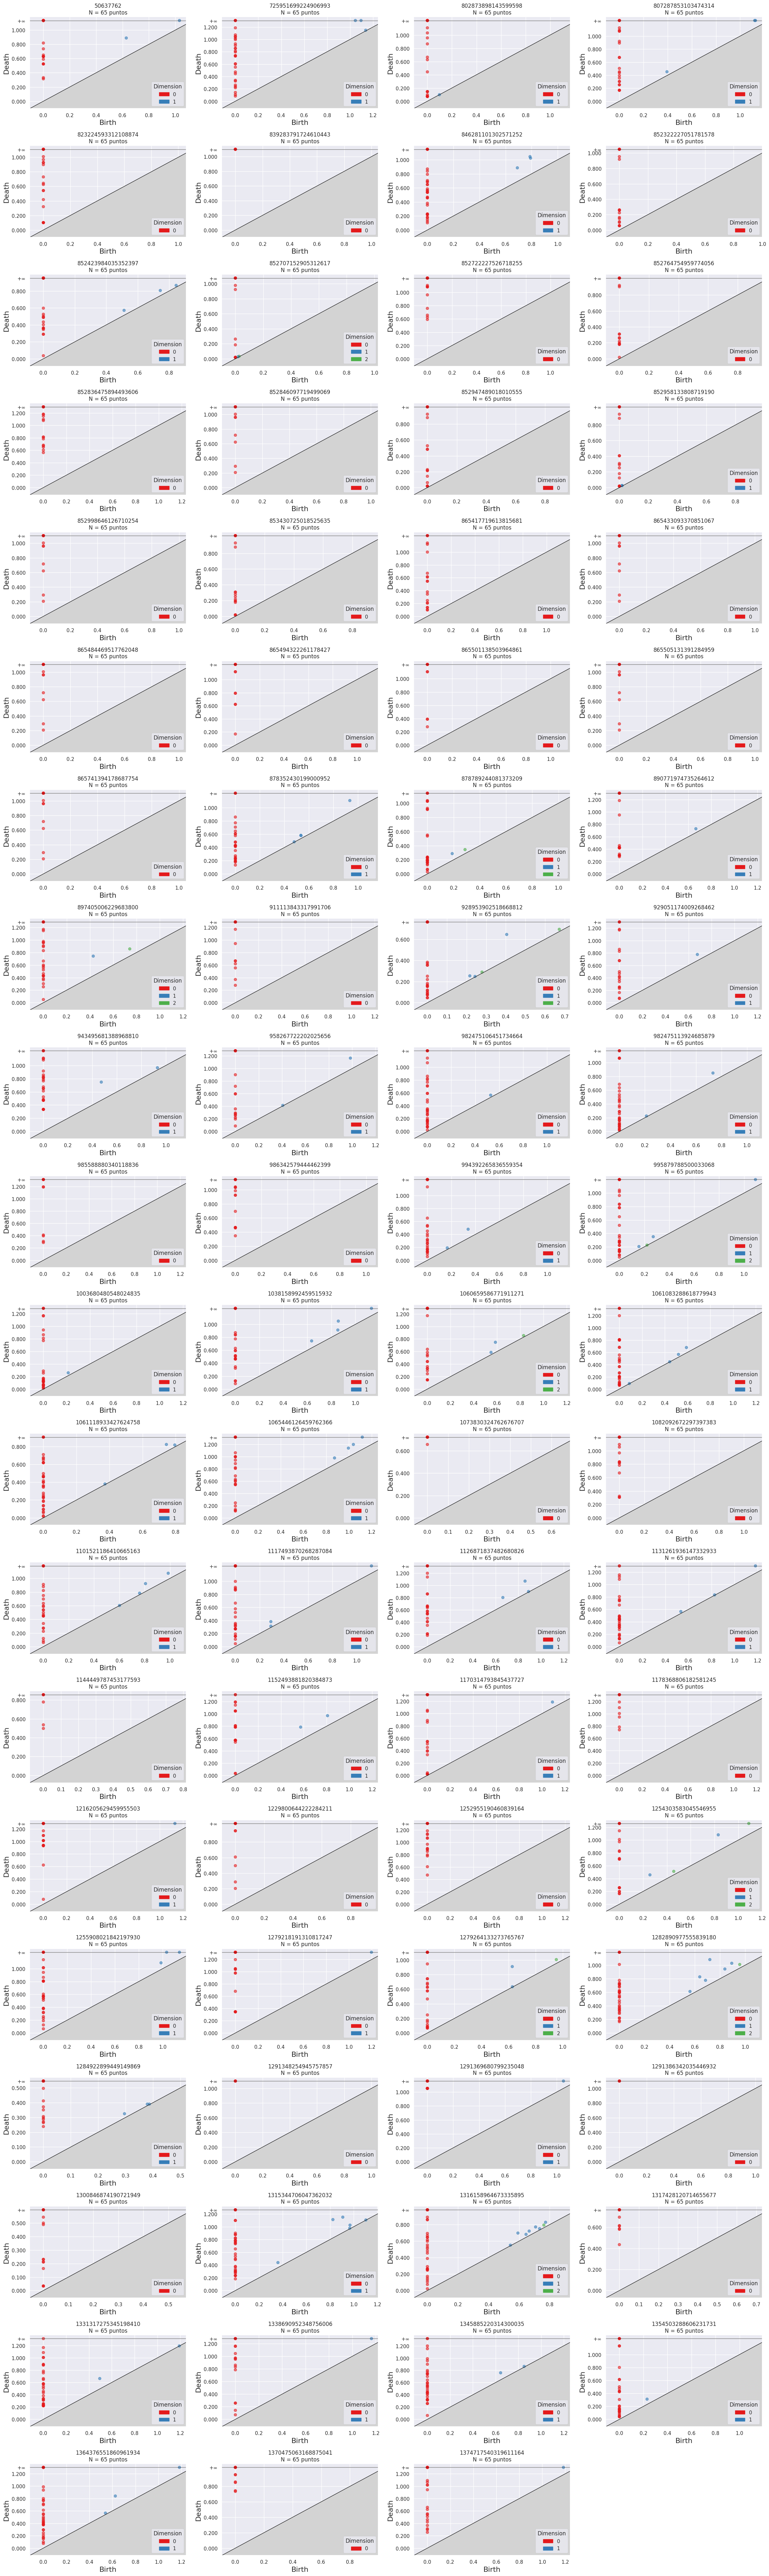

In [80]:
from sklearn.preprocessing import StandardScaler
import gudhi as gd
def delay_embedding(x, dim):
    """
    Convierte una serie 1D en una nube de puntos en ℝ^dim usando delay embedding.
    """
    return np.array([x[i:i+dim] for i in range(len(x) - dim + 1)])


embedding_dim = 3
max_edge_length = 1.2
max_dim = 3

diagrams_by_id = {}
points_by_id = {}

for id_val in df_prices["ID"].unique():
    series = df_prices[df_prices["ID"] == id_val].sort_values("Date")["Value"].values

    series = StandardScaler().fit_transform(series.reshape(-1, 1)).flatten()

    cloud = delay_embedding(series, dim=embedding_dim)
    points_by_id[id_val] = cloud.shape[0]

    rips = gd.RipsComplex(points=cloud, max_edge_length=max_edge_length)
    stree = rips.create_simplex_tree(max_dimension=max_dim)
    stree.compute_persistence()

    diagrams_by_id[id_val] = stree.persistence()

n = len(diagrams_by_id)
cols = 4
rows = int(np.ceil(n / cols))

fig = plt.figure(figsize=(cols * 6, rows * 4))
plt.tight_layout()

for i, group_key in enumerate(sorted(diagrams_by_id.keys())):
    ax = fig.add_subplot(rows, cols, i + 1)
    gd.plot_persistence_diagram(diagrams_by_id[group_key], axes=ax)
    ax.set_title(f"{group_key}\nN = {points_by_id[group_key]} puntos")

plt.tight_layout()
plt.show()

In [87]:
sec_longest_b0 = []
thi_longest_b0 = []
sum_b0 = []
mean_b0 = []
onset_longest_b1 = []
length_longest_b1 = []
smallest_onset_b1 = []
average_middle_b1 = []
sum_b1 = []
mean_b1 = []
b1_segment = []
b1_out_segment = []

group_labels = []

# Recorremos cada grupo de 'Base fee'
for group in sorted(diagrams_by_id.keys()):
    dgm = diagrams_by_id[group]
    n_atoms = points_by_id[group]

    # Extraer H0 y H1
    dgm_h0 = [pair for dim, pair in dgm if dim == 0]
    dgm_h1 = [pair for dim, pair in dgm if dim == 1]

    # --- H0 ---
    if len(dgm_h0) > 0:
        dgm_h0 = np.array(dgm_h0)
        lengths_b0 = dgm_h0[:,1] - dgm_h0[:,0]
        lengths_b0 = lengths_b0[lengths_b0 < 10000]  
        lengths_b0_sorted = np.sort(lengths_b0)[::-1]

        sec_longest_b0.append(lengths_b0_sorted[1] if len(lengths_b0_sorted) > 1 else 0)
        thi_longest_b0.append(lengths_b0_sorted[2] if len(lengths_b0_sorted) > 2 else 0)
        sum_b0.append(lengths_b0.sum() if len(lengths_b0) > 0 else 0)
        mean_b0.append(lengths_b0.mean() if len(lengths_b0) > 0 else 0)
    else:
        sec_longest_b0.append(0)
        thi_longest_b0.append(0)
        sum_b0.append(0)
        mean_b0.append(0)

    # --- H1 ---
    if len(dgm_h1) > 0:
        dgm_h1 = np.array(dgm_h1)
        births = dgm_h1[:,0]
        deaths = dgm_h1[:,1]
        valid = ~np.isinf(deaths)

        births = births[valid]
        deaths = deaths[valid]
        lengths = deaths - births
        midpoints = (births + deaths)/2

        onset_longest_b1.append(births[np.argmax(lengths)] if len(lengths) > 0 else 0)
        length_longest_b1.append(lengths.max() if len(lengths) > 0 else 0)
        smallest_onset_b1.append(births.min() if len(births) > 0 else 0)
        average_middle_b1.append(midpoints.mean() if len(midpoints) > 0 else 0)
        sum_b1.append(lengths.sum() if len(lengths) > 0 else 0)
        mean_b1.append(lengths.mean() if len(lengths) > 0 else 0)

        # Contar segmentos en rangos específicos
        in_segment = ((deaths <= 5.5) & (births >= 4.5)).sum()
        out_segment = (((deaths <= 6.5) & (births > 5.5)).sum() +
                       ((deaths < 4.5) & (births >= 3.5)).sum())

        b1_segment.append(in_segment / n_atoms if n_atoms > 0 else 0)
        b1_out_segment.append(out_segment / n_atoms if n_atoms > 0 else 0)
    else:
        onset_longest_b1.append(0)
        length_longest_b1.append(0)
        smallest_onset_b1.append(0)
        average_middle_b1.append(0)
        sum_b1.append(0)
        mean_b1.append(0)
        b1_segment.append(0)
        b1_out_segment.append(0)

    group_labels.append(group)

# Crear DataFrame final con todas las features
df_features = pd.DataFrame({
    "ID": group_labels,
    "sec_longest_b0": sec_longest_b0,
    "thi_longest_b0": thi_longest_b0,
    "sum_b0": sum_b0,
    "mean_b0": mean_b0,
    "onset_longest_b1": onset_longest_b1,
    "length_longest_b1": length_longest_b1,
    "smallest_onset_b1": smallest_onset_b1,
    "average_middle_b1": average_middle_b1,
    "sum_b1": sum_b1,
    "mean_b1": mean_b1,
    "b1_segment": b1_segment,
    "b1_out_segment": b1_out_segment
})

# Mostrar tabla
#print(df_features.head())
df_features = df_features.join(
    df_attributes.set_index("ID")[["Base fee"]],
    on="ID"
)
df_features = df_features.join(
    df_attributes.set_index("ID")[["Property type"]],
    on="ID"
)

print(df_features.head())

                   ID  sec_longest_b0  thi_longest_b0     sum_b0   mean_b0  \
0            50637762        0.736511        0.649345   7.527201  0.579015   
1  725951699224906993        1.072574        1.046385  18.093493  0.646196   
2  802873898143599598        1.031751        0.956538   6.594779  0.412174   
3  807287853103474314        1.092289        1.076010  11.287463  0.564373   
4  823224593312108874        0.967076        0.928005   8.953086  0.559568   

   onset_longest_b1  length_longest_b1  smallest_onset_b1  average_middle_b1  \
0          0.628762           0.260442           0.628762           0.758983   
1          1.136306           0.011180           1.136306           1.141896   
2          0.097842           0.000385           0.097842           0.098034   
3          0.394099           0.058374           0.394099           0.423286   
4          0.000000           0.000000           0.000000           0.000000   

     sum_b1   mean_b1  b1_segment  b1_out_segment 

In [86]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Variables
feature_names = [
    'sec_longest_b0', 'thi_longest_b0', 'sum_b0', 'mean_b0',
    'onset_longest_b1', 'length_longest_b1', 'smallest_onset_b1',
    'average_middle_b1', 'sum_b1', 'mean_b1', 'b1_segment', 'b1_out_segment'
]

X = df_features[feature_names]
y = df_features['Base fee']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

# Modelos y sus grids
models_and_grids = {
    "RandomForest": {
        "model": RandomForestRegressor(random_state=42),
        "params": {
            "model__n_estimators": [100, 200],
            "model__max_depth": [None, 10]
        }
    },
    "GradientBoosting": {
        "model": GradientBoostingRegressor(random_state=42),
        "params": {
            "model__n_estimators": [100, 200],
            "model__learning_rate": [0.05, 0.1]
        }
    },
    "SVR": {
        "model": SVR(),
        "params": {
            "model__C": [1.0, 10.0],
            "model__epsilon": [0.1, 1.0]
        }
    }
}

results = {}

for name, setup in models_and_grids.items():
    print(f"\n🔍 Entrenando modelo: {name}")
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', setup["model"])
    ])

    grid = GridSearchCV(pipeline, setup["params"], cv=5, scoring='r2', n_jobs=-1, verbose=0)
    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)

    results[name] = {
        "R2": r2,
        "RMSE": rmse,
        "Best params": grid.best_params_,
        "Model": best_model
    }

    print(f"✅ {name} - R²: {r2:.4f}, RMSE: {rmse:.4f}")
    print(f"Mejores hiperparámetros: {grid.best_params_}")



🔍 Entrenando modelo: RandomForest


c:\Users\EdsonAlvarez\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



✅ RandomForest - R²: -0.6526, RMSE: 19.6111
Mejores hiperparámetros: {'model__max_depth': None, 'model__n_estimators': 200}

🔍 Entrenando modelo: GradientBoosting
✅ GradientBoosting - R²: -0.7722, RMSE: 20.3086
Mejores hiperparámetros: {'model__learning_rate': 0.05, 'model__n_estimators': 100}

🔍 Entrenando modelo: SVR
✅ SVR - R²: -0.3228, RMSE: 17.5455
Mejores hiperparámetros: {'model__C': 1.0, 'model__epsilon': 1.0}


c:\Users\EdsonAlvarez\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

c:\Users\EdsonAlvarez\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



In [89]:
results

{'RandomForest': {'R2': -0.652597119177005,
  'RMSE': 19.611104906146824,
  'Best params': {'model__max_depth': None, 'model__n_estimators': 200},
  'Model': Pipeline(steps=[('scaler', StandardScaler()),
                  ('model',
                   RandomForestRegressor(n_estimators=200, random_state=42))])},
 'GradientBoosting': {'R2': -0.7722403874766395,
  'RMSE': 20.3085951433414,
  'Best params': {'model__learning_rate': 0.05, 'model__n_estimators': 100},
  'Model': Pipeline(steps=[('scaler', StandardScaler()),
                  ('model',
                   GradientBoostingRegressor(learning_rate=0.05,
                                             random_state=42))])},
 'SVR': {'R2': -0.322807087886966,
  'RMSE': 17.545543425160496,
  'Best params': {'model__C': 1.0, 'model__epsilon': 1.0},
  'Model': Pipeline(steps=[('scaler', StandardScaler()), ('model', SVR(epsilon=1.0))])}}

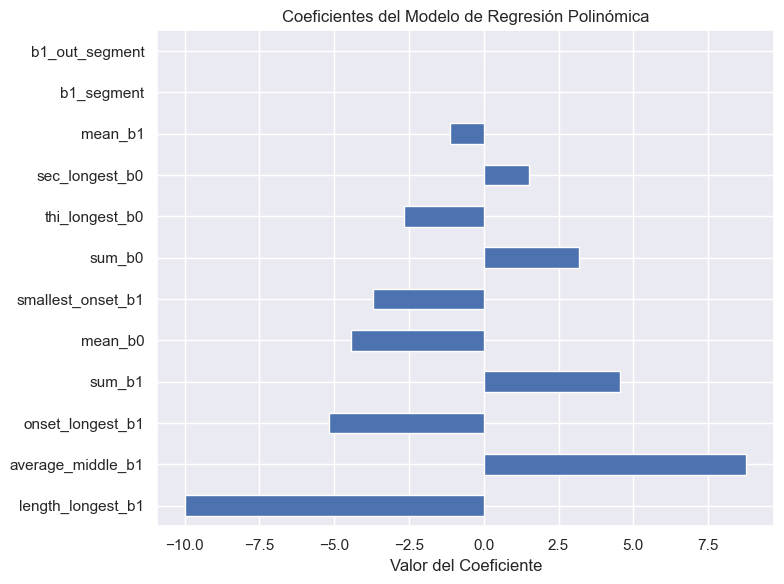

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set()

# Acceder a los pasos del pipeline
poly = best_model.named_steps['poly']
lr = best_model.named_steps['lr']

# Obtener nombres de las características polinómicas
poly_feature_names = poly.get_feature_names_out(feature_names)

# Crear serie de coeficientes
coef_series = pd.Series(lr.coef_, index=poly_feature_names)

# Mostrar los coeficientes con mayor valor absoluto
top_coefs = coef_series.reindex(coef_series.abs().sort_values(ascending=False).index)

# Graficar
top_coefs.head(20).plot(kind='barh', figsize=(8, 6))  # top 20 para no saturar
plt.title("Coeficientes del Modelo de Regresión Polinómica")
plt.xlabel("Valor del Coeficiente")
plt.tight_layout()
plt.show()


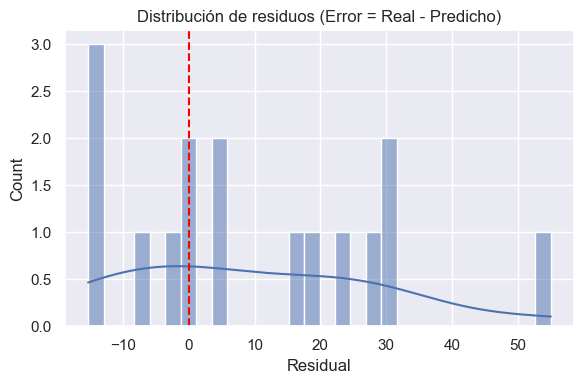

In [85]:
residuals = y_test - y_pred

plt.figure(figsize=(6, 4))
sns.histplot(residuals, bins=30, kde=True)
plt.axvline(0, color='red', linestyle='--')
plt.title("Distribución de residuos (Error = Real - Predicho)")
plt.xlabel("Residual")
plt.tight_layout()
plt.show()


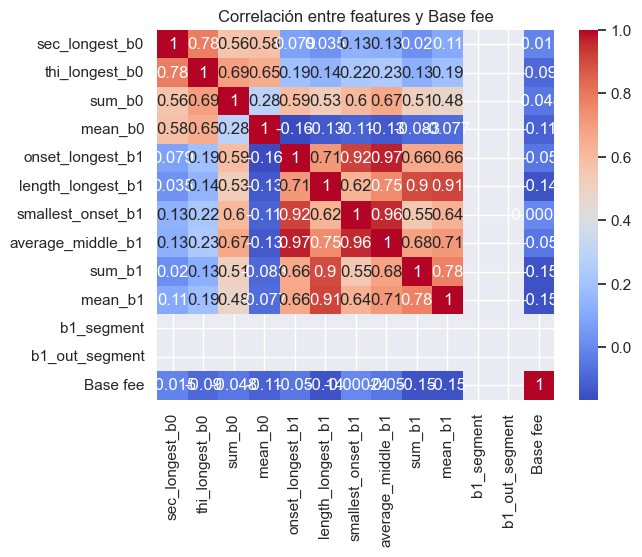

In [90]:
corr = df_features[feature_names + ['Base fee']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlación entre features y Base fee")
plt.show()

In [91]:
corr

,sec_longest_b0,thi_longest_b0,sum_b0,mean_b0,onset_longest_b1,length_longest_b1,smallest_onset_b1,average_middle_b1,sum_b1,mean_b1,b1_segment,b1_out_segment,Base fee
sec_longest_b0,1.000000,0.782103,0.564592,0.579099,0.078966,0.035008,0.133279,0.125833,0.020141,0.105438,NaN,NaN,-0.014732
thi_longest_b0,0.782103,1.000000,0.694591,0.651969,0.193566,0.144038,0.217772,0.232509,0.127952,0.186244,NaN,NaN,-0.089967
sum_b0,0.564592,0.694591,1.000000,0.281996,0.591761,0.527101,0.604717,0.665757,0.512515,0.482412,NaN,NaN,-0.047758
mean_b0,0.579099,0.651969,0.281996,1.000000,-0.164942,-0.128008,-0.105061,-0.125197,-0.083272,-0.076535,NaN,NaN,-0.108280
onset_longest_b1,0.078966,0.193566,0.591761,-0.164942,1.000000,0.712660,0.916454,0.968381,0.659834,0.663323,NaN,NaN,-0.050353
length_longest_b1,0.035008,0.144038,0.527101,-0.128008,0.712660,1.000000,0.624212,0.747032,0.898986,0.912985,NaN,NaN,-0.143092
smallest_onset_b1,0.133279,0.217772,0.604717,-0.105061,0.916454,0.624212,1.000000,0.957673,0.551161,0.635906,NaN,NaN,-0.000237
average_middle_b1,0.125833,0.232509,0.665757,-0.125197,0.968381,0.747032,0.957673,1.000000,0.682408,0.711655,NaN,NaN,-0.050275
sum_b1,0.020141,0.127952,0.512515,-0.083272,0.659834,0.898986,0.551161,0.682408,1.000000,0.776058,NaN,NaN,-0.145398
mean_b1,0.105438,0.186244,0.482412,-0.076535,0.663323,0.912985,0.635906,0.711655,0.776058,1.000000,NaN,NaN,-0.147476
